In [4]:
import numpy as np
import multiprocessing
from multiprocessing import sharedctypes
import ctypes
from squanch import qstream, gates, agent
import matplotlib.image as image
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
N, dim = 10, 2**2
shared_mem = sharedctypes.RawArray(ctypes.c_double, N * dim**2) 
arr = np.frombuffer(shared_mem, dtype=np.complex64).reshape((N, dim, dim))

In [4]:
class Test(multiprocessing.Process):
    def __init__(self, arr, index):
        multiprocessing.Process.__init__(self)
        self.arr = arr 
        self.index = index 
    def run(self):
        self.arr[self.index] = -1 
        print self.index, "done", self.arr[:]

In [5]:
sims = []
arr = sharedctypes.RawArray(ctypes.c_int, 10)

for i in range(10):
    sims.append(Test(arr, i))

In [6]:
for sim in sims:
    sim.start()
    sim.join()

0 done [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


1 done [-1, -1, 0, 0, 0, 0, 0, 0, 0, 0]


2 done [-1, -1, -1, 0, 0, 0, 0, 0, 0, 0]


3 done [-1, -1, -1, -1, 0, 0, 0, 0, 0, 0]


4 done [-1, -1, -1, -1, -1, 0, 0, 0, 0, 0]


5 done [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0]


6 done [-1, -1, -1, -1, -1, -1, -1, 0, 0, 0]


7 done [-1, -1, -1, -1, -1, -1, -1, -1, 0, 0]


8 done [-1, -1, -1, -1, -1, -1, -1, -1, -1, 0]


9 done [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]


## Multiprocessed agent demonstration

In [2]:
# Load the image 
imgData = image.imread("img/foundryLogo.bmp")

# Convert the image array to a bitstream
aliceData = np.unpackbits(imgData)
bobData = np.zeros(aliceData.size, dtype = np.uint8)

In [8]:
class Charlie(agent.Agent):
    
    def run(self): 
        for i in range(size):
            a,b = self.stream.head().qubits 
            gates.H(a) 
            gates.CNOT(a,b)
            self.qsend(alice, a)
            self.qsend(bob, b) 
        print "Charlie is done!"
        
class Alice(agent.Agent):
    
    def run(self):
        for i in range(size): 
            bit1, bit2 = aliceData[2*i], aliceData[2*i + 1]
            q = alice.qrecv(charlie)
            if q is not None:
                if bit2 == 1: gates.X(q)
                if bit1 == 1: gates.Z(q)
            alice.qsend(bob, q)
        print "Alice is done!"
        
class Bob(agent.Agent):
    
    def run(self): 
        for i in range(size):
            a = self.qrecv(alice)
            c = self.qrecv(charlie) 
            if a is not None and c is not None:
                gates.CNOT(a,c)
                gates.H(a)
                bobData[2*i] = a.measure() 
                bobData[2*i + 1] = c.measure() 
        self.output(bobData)
        print "Bob is done!"

Charlie is done!


Alice is done!


Bob is done!


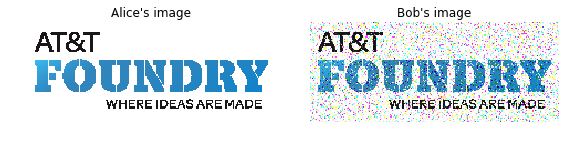

In [9]:
# Simulate sending an image with superdense coding over an Alice-Bob-Charlie system
size = len(aliceData) / 2 # Alice's image as a bitstream
# stream = QStream(2, size) 
mem = qstream.QStream.generateSharedHilbertSpace(2, size)
out = agent.Agent.generateOutputDict()

alice = Alice("Alice", mem) # Sender
bob = Bob("Bob", mem, outDict = out) # Receiver
charlie = Charlie("Charlie", mem) # Pair distributor

agent.connectAgents(alice, bob, length = 1.0) 
agent.connectAgents(alice, charlie, length = 0.5)
agent.connectAgents(bob, charlie, length = 0.5)

alice.start()
bob.start()
charlie.start()

alice.join()
bob.join()
charlie.join()

recData = out["Bob"]
receivedArray = np.reshape(np.packbits(recData), imgData.shape)
f, ax = plt.subplots(1, 2, figsize = (8,4))
ax[0].imshow(imgData)
ax[0].axis('off')
ax[0].title.set_text("Alice's image")
ax[1].imshow(receivedArray)
ax[1].axis('off')
ax[1].title.set_text("Bob's image")
plt.tight_layout()
plt.show()